# Week 2 assignments

In [0]:
#@title Imports and functions

import numpy as np
from scipy.fftpack import dct, idct, fft2
from scipy.misc import face
from scipy.ndimage.measurements import histogram as img_hist
import matplotlib.pyplot as plt
import math


lena = face(gray=True)
block_size = 8
zigzag = []
Z_Y = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]])
Z_C = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]])
mask_8coefs = np.array([
    1, 1, 1, 1, 0, 0, 0, 0,
    1, 1, 1, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0]).reshape((8, 8))


def crop_image(image, block_size):
    if image.shape[0] % block_size != 0:
        cropped_width = math.floor(int(image.shape[0] / block_size) * block_size)
    else:
        cropped_width = image.shape[0]

    if image.shape[1] % block_size != 0:
        cropped_height = math.floor(int(image.shape[1] / block_size) * block_size)
    else:
        cropped_height = image.shape[1]

    cropped_image = np.zeros((cropped_width, cropped_height))

    for rownum in range(len(cropped_image)):
       for colnum in range(len(cropped_image[rownum])):
           cropped_image[rownum][colnum] = image[rownum][colnum]

    return cropped_image


def divide_image(image, block_size):
    rows = range(0,image.shape[0],block_size)
    cols = range(0,image.shape[1],block_size)
    blocks = []
    for i in rows:
        for j in cols:
            blocks.append(np.array([image[i:i+block_size, j:j+block_size]]))
    return blocks, len(rows), len(cols)


def sew_blocks(blocks, block_size, grid_shape):
    rowsize, colsize = grid_shape
    img = np.zeros((block_size*rowsize, block_size*colsize))
    for i in range(0, rowsize):
        for j in range(0, colsize):
            try:
                img[i:i+block_size, j:j+block_size] = np.squeeze(blocks[i*colsize+j])
            except ValueError as e:
                print(f"i (row) = {i}\t\tj (column) = {j}\t\tblock.shape = {blocks[i*colsize+j].shape}")
                raise ValueError
    return img


def partition(image, block_size):
    data = np.split(image, image.shape[0] / block_size)
    res = []

    for arr in data:
        res.append(np.split(arr, arr.shape[1] / block_size, axis=1))

    return res


def zig_zag(input_matrix, block_size):
    z = np.empty([block_size*block_size])
    index = -1
    bound = 0
    for i in range(0, 2 * block_size -1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                z[index] = input_matrix[j, i-j]
            else:
                z[index] = input_matrix[i-j, j]
    return z


def dctmtx(block_size):
    dct_matrix = np.zeros((block_size, block_size))

    for i in range(0, block_size):
        for j in range(0, block_size):
            if i == 0:
                dct_matrix[i][j] = 1/math.sqrt(block_size)
            else:
                dct_matrix[i][j] = math.sqrt(2/block_size) * math.cos((math.pi*(2 * j + 1) * i)/(2*block_size))

    return dct_matrix


def dct2d(image):
    return np.matmul(np.matmul(dctmtx(block_size), image), dctmtx(block_size).T)

## 1. Implement JPEG

1. Divide the image into non-overlapping 8x8 blocks
1. Perform DCT on each block
1. Quantize each block using tables or one fix scalar
1. Try preserving the first 8 coefficients instead of all the 8x8=64
1. Invert the process and visualize the differences

In [0]:
#@title Initialization
blocks, rowsize, colsize = divide_image(crop_image(lena, block_size), block_size)

print(f"Blocks length: {len(blocks)}")
print(f"Grid shape: ({rowsize}, {colsize})")

quantized_dct_x1 = np.zeros((block_size, block_size))
quantized_dct_x2 = np.zeros((block_size, block_size))
dct_first8 = np.zeros((block_size, block_size))
block_coefs = np.zeros((block_size, block_size))

quantized_x1_coefs, quantized_x2_coefs, dct_8coefs = [], [], []
blocks_q1, blocks_q2, blocks_f8 = [], [], []

Blocks length: 12288
Grid shape: (96, 128)


In [0]:
#@title Compression
for block in blocks:
    # dct
    block_coefs = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
    # block_coefs = dct(dct(block, axis=0, norm=None), axis=1, norm=None)
    # block_coefs = dct2d(block)

    # quantization
    quantized_dct_x1 = (block_coefs // Z_Y) * Z_Y
    quantized_dct_x2 = (block_coefs // (Z_Y * 2)) * Z_Y
    dct_first8 = mask_8coefs * block_coefs

    # save
    quantized_x1_coefs.append(quantized_dct_x1)
    quantized_x2_coefs.append(quantized_dct_x2)
    dct_8coefs.append(dct_first8)

In [0]:
#@title Decoding
for q1, q2, f8 in zip(quantized_x1_coefs, quantized_x2_coefs, dct_8coefs):
    # anti-transform
    blocks_q1.append(idct(idct(q1, axis=0, norm='ortho'), axis=1, norm='ortho'))
    blocks_q2.append(idct(idct(q2, axis=0, norm='ortho'), axis=1, norm='ortho'))
    blocks_f8.append(idct(idct(f8, axis=0, norm='ortho'), axis=1, norm='ortho'))

    # blocks_q1.append(dct(dct(q1, axis=0, norm='None'), axis=1, norm='None'))
    # blocks_q2.append(dct(dct(q2, axis=0, norm='None'), axis=1, norm='None'))
    # blocks_f8.append(dct(dct(f8, axis=0, norm='None'), axis=1, norm='None'))

    # blocks_q1.append(dct2d(q1))
    # blocks_q2.append(dct2d(q2))
    # blocks_f8.append(dct2d(f8))

# Seam back together
blocks_q1 = sew_blocks(blocks_q1, block_size, (rowsize, colsize))
blocks_q2 = sew_blocks(blocks_q2, block_size, (rowsize, colsize))
blocks_f8 = sew_blocks(blocks_f8, block_size, (rowsize, colsize))

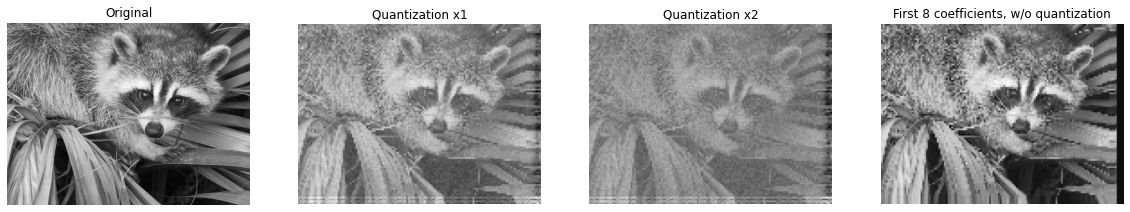

In [0]:
#@title Plotting

plt.figure(figsize=(20,40))
plt.subplot(141)
plt.imshow(lena, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(142)
plt.imshow(blocks_q1[:100,:135], cmap='gray')
plt.title("Quantization x1")
plt.axis('off')
plt.subplot(143)
plt.imshow(blocks_q2[:100,:135], cmap='gray')
plt.title("Quantization x2")
plt.axis('off')
plt.subplot(144)
plt.imshow(blocks_f8[:100,:135], cmap='gray')
plt.title("First 8 coefficients, w/o quantization")
plt.axis('off')
plt.show()

## 2. JPEG with FFT

Follow the same process but with the FFT instead of the DCT:

1. Divide the image into non-overlapping 8x8 blocks
1. Perform FFT on each block
1. Quantize each block using tables or one fix scalar
1. Try preserving the first 8 coefficients instead of all the 8x8=64
1. Invert the process and visualize the differences

In [0]:
#@title Initialization
blocks, rowsize, colsize = divide_image(crop_image(lena, block_size), block_size)

print(f"Blocks length: {len(blocks)}")
print(f"Grid shape: ({rowsize}, {colsize})")

quantized_fft_x1 = np.zeros((block_size, block_size))
quantized_fft_x2 = np.zeros((block_size, block_size))
fft_first8 = np.zeros((block_size, block_size))
block_coefs = np.zeros((block_size, block_size))

quantized_x1_coefs, quantized_x2_coefs, fft_8coefs = [], [], []
blocks_q1, blocks_q2, blocks_f8 = [], [], []

Blocks length: 12288
Grid shape: (96, 128)


In [0]:
#@title Compression
for block in blocks:
    # dct
    block_coefs = fft2(block)

    # quantization
    quantized_fft_x1 = (block_coefs // Z_Y) * Z_Y
    quantized_fft_x2 = (block_coefs // (Z_Y * 2)) * Z_Y
    dct_first8 = mask_8coefs * block_coefs

    # save
    quantized_x1_coefs.append(quantized_fft_x1)
    quantized_x2_coefs.append(quantized_fft_x2)
    fft_8coefs.append(fft_first8)

In [0]:
#@title Decoding
for q1, q2, f8 in zip(quantized_x1_coefs, quantized_x2_coefs, fft_8coefs):
    # anti-transform
    blocks_q1.append(np.abs(fft2(q1)))
    blocks_q2.append(np.abs(fft2(q2)))
    blocks_f8.append(np.abs(fft2(f8)))

# Seam back together
blocks_q1 = sew_blocks(blocks_q1, block_size, (rowsize, colsize))
blocks_q2 = sew_blocks(blocks_q2, block_size, (rowsize, colsize))
blocks_f8 = sew_blocks(blocks_f8, block_size, (rowsize, colsize))

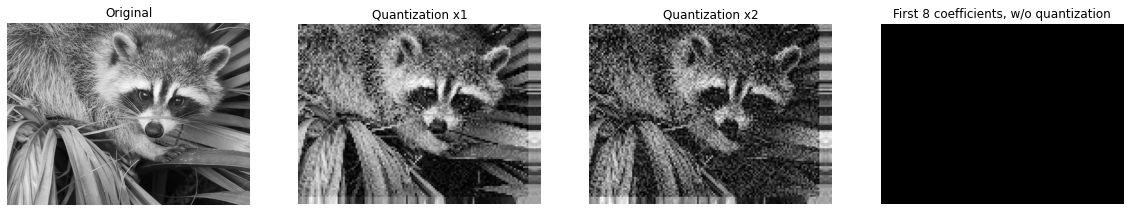

In [0]:
#@title Plotting

plt.figure(figsize=(20,40))
plt.subplot(141)
plt.imshow(lena, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(142)
plt.imshow(blocks_q1[:100,:135], cmap='gray')
plt.title("Quantization x1")
plt.axis('off')
plt.subplot(143)
plt.imshow(blocks_q2[:100,:135], cmap='gray')
plt.title("Quantization x2")
plt.axis('off')
plt.subplot(144)
plt.imshow(blocks_f8[:100,:135], cmap='gray')
plt.title("First 8 coefficients, w/o quantization")
plt.axis('off')
plt.show()

## 3. JPEG-style compression without transform

Follow all the JPEG compression steps except for the transform.

In [0]:
#@title Quantization

# The purpose of the blocks is to parallelize the processing of the transform
# so I am skipping it

lena_quant = (np.floor(lena // 16) * 16).astype('uint8')

array([[112, 128, 144, ..., 112, 128, 128],
       [ 80,  96, 112, ..., 112, 128, 144],
       [ 64,  80,  96, ..., 112, 128, 144],
       ...,
       [ 96,  96, 112, ..., 144, 128, 128],
       [ 80,  96, 112, ..., 128, 128, 128],
       [ 80,  96, 112, ..., 128, 128, 128]], dtype=uint8)

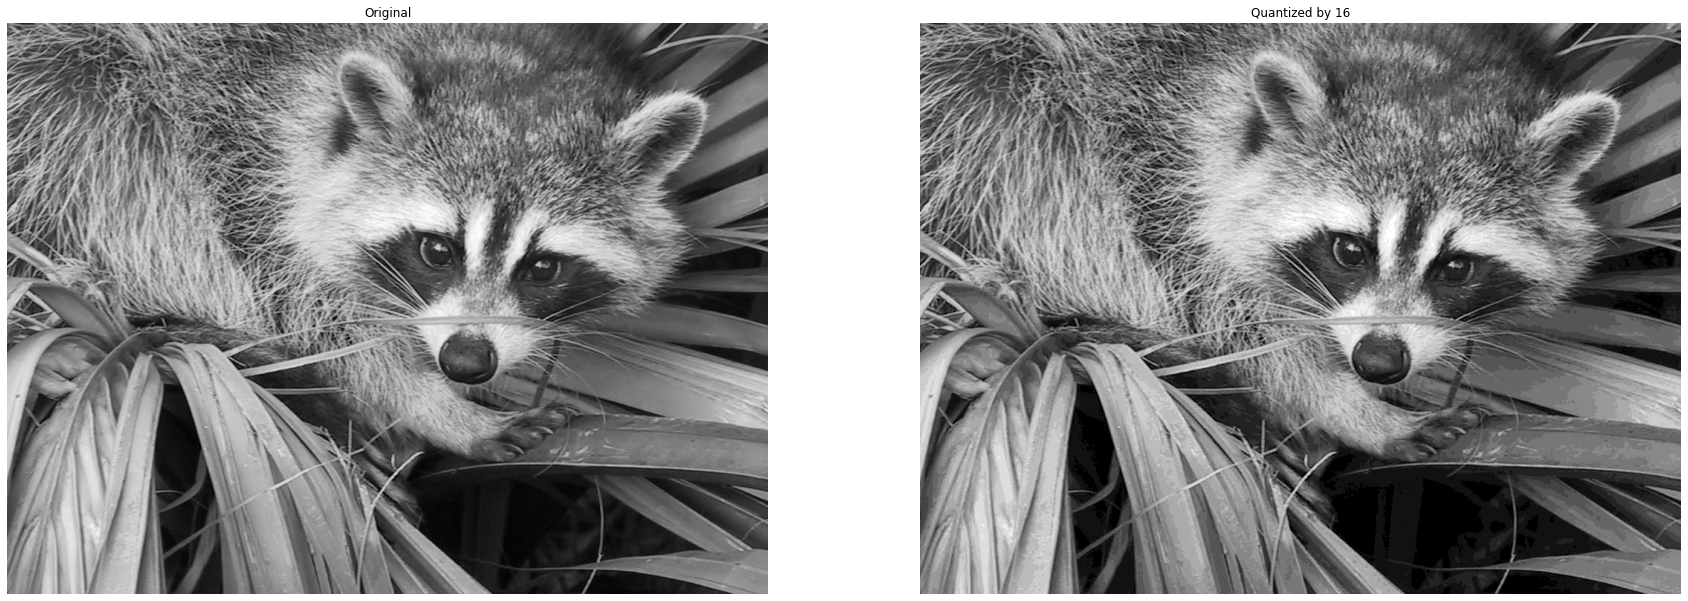

In [0]:
#@title Plotting
plt.figure(figsize=(30, 60))
plt.subplot(121)
plt.imshow(lena, cmap='gray')
plt.axis('off')
plt.title("Original")

plt.subplot(122)
plt.imshow(lena_quant, cmap='gray')
plt.title("Quantized by 16")
plt.axis('off')
plt.show()

## 4. JPEG on color image

1. Convert an image to YCbCr and perform JPEG compression on each channel independently and visualize the results of the inversion
1. Keep the compression ratio constant for the Y channel and increase the compression of the two chrominance channels, observe the results

In [0]:
#@title Initialization
from PIL import Image
raccoon_ycbcr = np.asarray(Image.fromarray(face(gray=False), 'YCbCr'),
                           dtype='uint8')
raccoon_ycbcr.shape

(768, 1024, 3)

In [0]:
blocks_ycbcr = [divide_image(crop_image(np.squeeze(raccoon_ycbcr[:,:,x]),
                                  block_size),
                       block_size) \
          for x in range(raccoon_ycbcr.shape[2])]

rowsize, colsize = blocks_ycbcr[0][1:]

print(f"Blocks length: {len(blocks_ycbcr[0][0])}")
print(f"Grid shape: ({rowsize}, {colsize})")

Blocks length: 12288
Grid shape: (96, 128)


In [0]:
print(np.squeeze(blocks_ycbcr[1][0][0]))

[[112. 129. 144. 146. 146. 148. 149. 146.]
 [ 82. 103. 122. 129. 133. 140. 144. 143.]
 [ 66.  87. 108. 115. 119. 123. 124. 121.]
 [ 77.  93. 109. 115. 120. 121. 115. 106.]
 [ 99. 109. 119. 127. 137. 142. 135. 122.]
 [122. 126. 128. 134. 147. 160. 160. 152.]
 [108. 109. 107. 107. 121. 143. 157. 161.]
 [ 68.  69.  66.  65.  80. 111. 141. 155.]]


In [0]:
quantized_dct_x1 = np.zeros((block_size, block_size))
quantized_dct_x2 = np.zeros((block_size, block_size))
quantized_dct_x3 = np.zeros((block_size, block_size))
block_coefs = np.zeros((block_size, block_size))

quantized_x1_coefs, quantized_x2_coefs, quantized_x3_coefs = [[]]*3, [[]]*3, [[]]*3
blocks_q1, blocks_q2, blocks_q3 = [[]]*3, [[]]*3, [[]]*3

In [0]:
#@title Compression
for i, c in enumerate(blocks_ycbcr):
    for b in c[0]:
        # dct
        block_coefs = dct(dct(np.squeeze(b).astype('float32'),
                            axis=0, norm='ortho'),
                        axis=1, norm='ortho')
        # block_coefs = dct(dct(block, axis=0, norm=None), axis=1, norm=None)
        # block_coefs = dct2d(block)

        # quantization
        if i == 0:
            quantized_dct_x1 = (block_coefs // Z_Y) * Z_Y
            quantized_dct_x2 = (block_coefs // Z_Y) * Z_Y
            quantized_dct_x3 = (block_coefs // Z_Y) * Z_Y
        else:
            quantized_dct_x1 = (block_coefs // Z_Y) * Z_Y
            quantized_dct_x2 = (block_coefs // (Z_Y * 2)) * Z_Y
            quantized_dct_x3 = (block_coefs // (Z_Y * 3)) * Z_Y

        # save
        quantized_x1_coefs[i].append(quantized_dct_x1)
        quantized_x2_coefs[i].append(quantized_dct_x2)
        quantized_x3_coefs[i].append(quantized_dct_x3)

In [0]:
#@title Decoding
for c in range(3):
    for q1, q2, q3 in zip(quantized_x1_coefs[c],
                          quantized_x2_coefs[c],
                          quantized_x3_coefs[c]):
        # anti-transform
        blocks_q1[c].append(dct(dct(q1, axis=0, norm='ortho'), axis=1, norm='ortho'))
        blocks_q2[c].append(dct(dct(q2, axis=0, norm='ortho'), axis=1, norm='ortho'))
        blocks_q3[c].append(dct(dct(q3, axis=0, norm='ortho'), axis=1, norm='ortho'))

        # blocks_q1[c].append(dct(dct(q1, axis=0, norm='None'), axis=1, norm='None'))
        # blocks_q2[c].append(dct(dct(q2, axis=0, norm='None'), axis=1, norm='None'))
        # blocks_q3[c].append(dct(dct(q3, axis=0, norm='None'), axis=1, norm='None'))

        # blocks_q1[c].append(dct2d(q1))
        # blocks_q2[c].append(dct2d(q2))
        # blocks_q3[c].append(dct2d(q3))

# Sew back together
blocks_q1 = [sew_blocks(blocks_q1[c], block_size, (rowsize, colsize)) for c in range(3)]
blocks_q2 = [sew_blocks(blocks_q2[c], block_size, (rowsize, colsize)) for c in range(3)]
blocks_q3 = [sew_blocks(blocks_q3[c], block_size, (rowsize, colsize)) for c in range(3)]

In [0]:
blocks_q1 = np.array(blocks_q1).astype('uint8').reshape(raccoon_ycbcr.shape)
blocks_q2 = np.array(blocks_q2).astype('uint8').reshape(raccoon_ycbcr.shape)
blocks_q3 = np.array(blocks_q3).astype('uint8').reshape(raccoon_ycbcr.shape)

q1_y, q1_cb, q1_cr = Image.fromarray(blocks_q1[0], mode='L'), Image.fromarray(blocks_q1[1], mode='L'), Image.fromarray(blocks_q1[2], mode='L')
q2_y, q2_cb, q2_cr = Image.fromarray(blocks_q2[0], mode='L'), Image.fromarray(blocks_q2[1], mode='L'), Image.fromarray(blocks_q2[2], mode='L')
q3_y, q3_cb, q3_cr = Image.fromarray(blocks_q3[0], mode='L'), Image.fromarray(blocks_q3[1], mode='L'), Image.fromarray(blocks_q3[2], mode='L')

blocks_q1 = Image.merge('YCbCr', (q1_y, q1_cb, q1_cr)).convert('RGB')
blocks_q2 = Image.merge('YCbCr', (q2_y, q2_cb, q2_cr)).convert('RGB')
blocks_q3 = Image.merge('YCbCr', (q3_y, q3_cb, q3_cr)).convert('RGB')

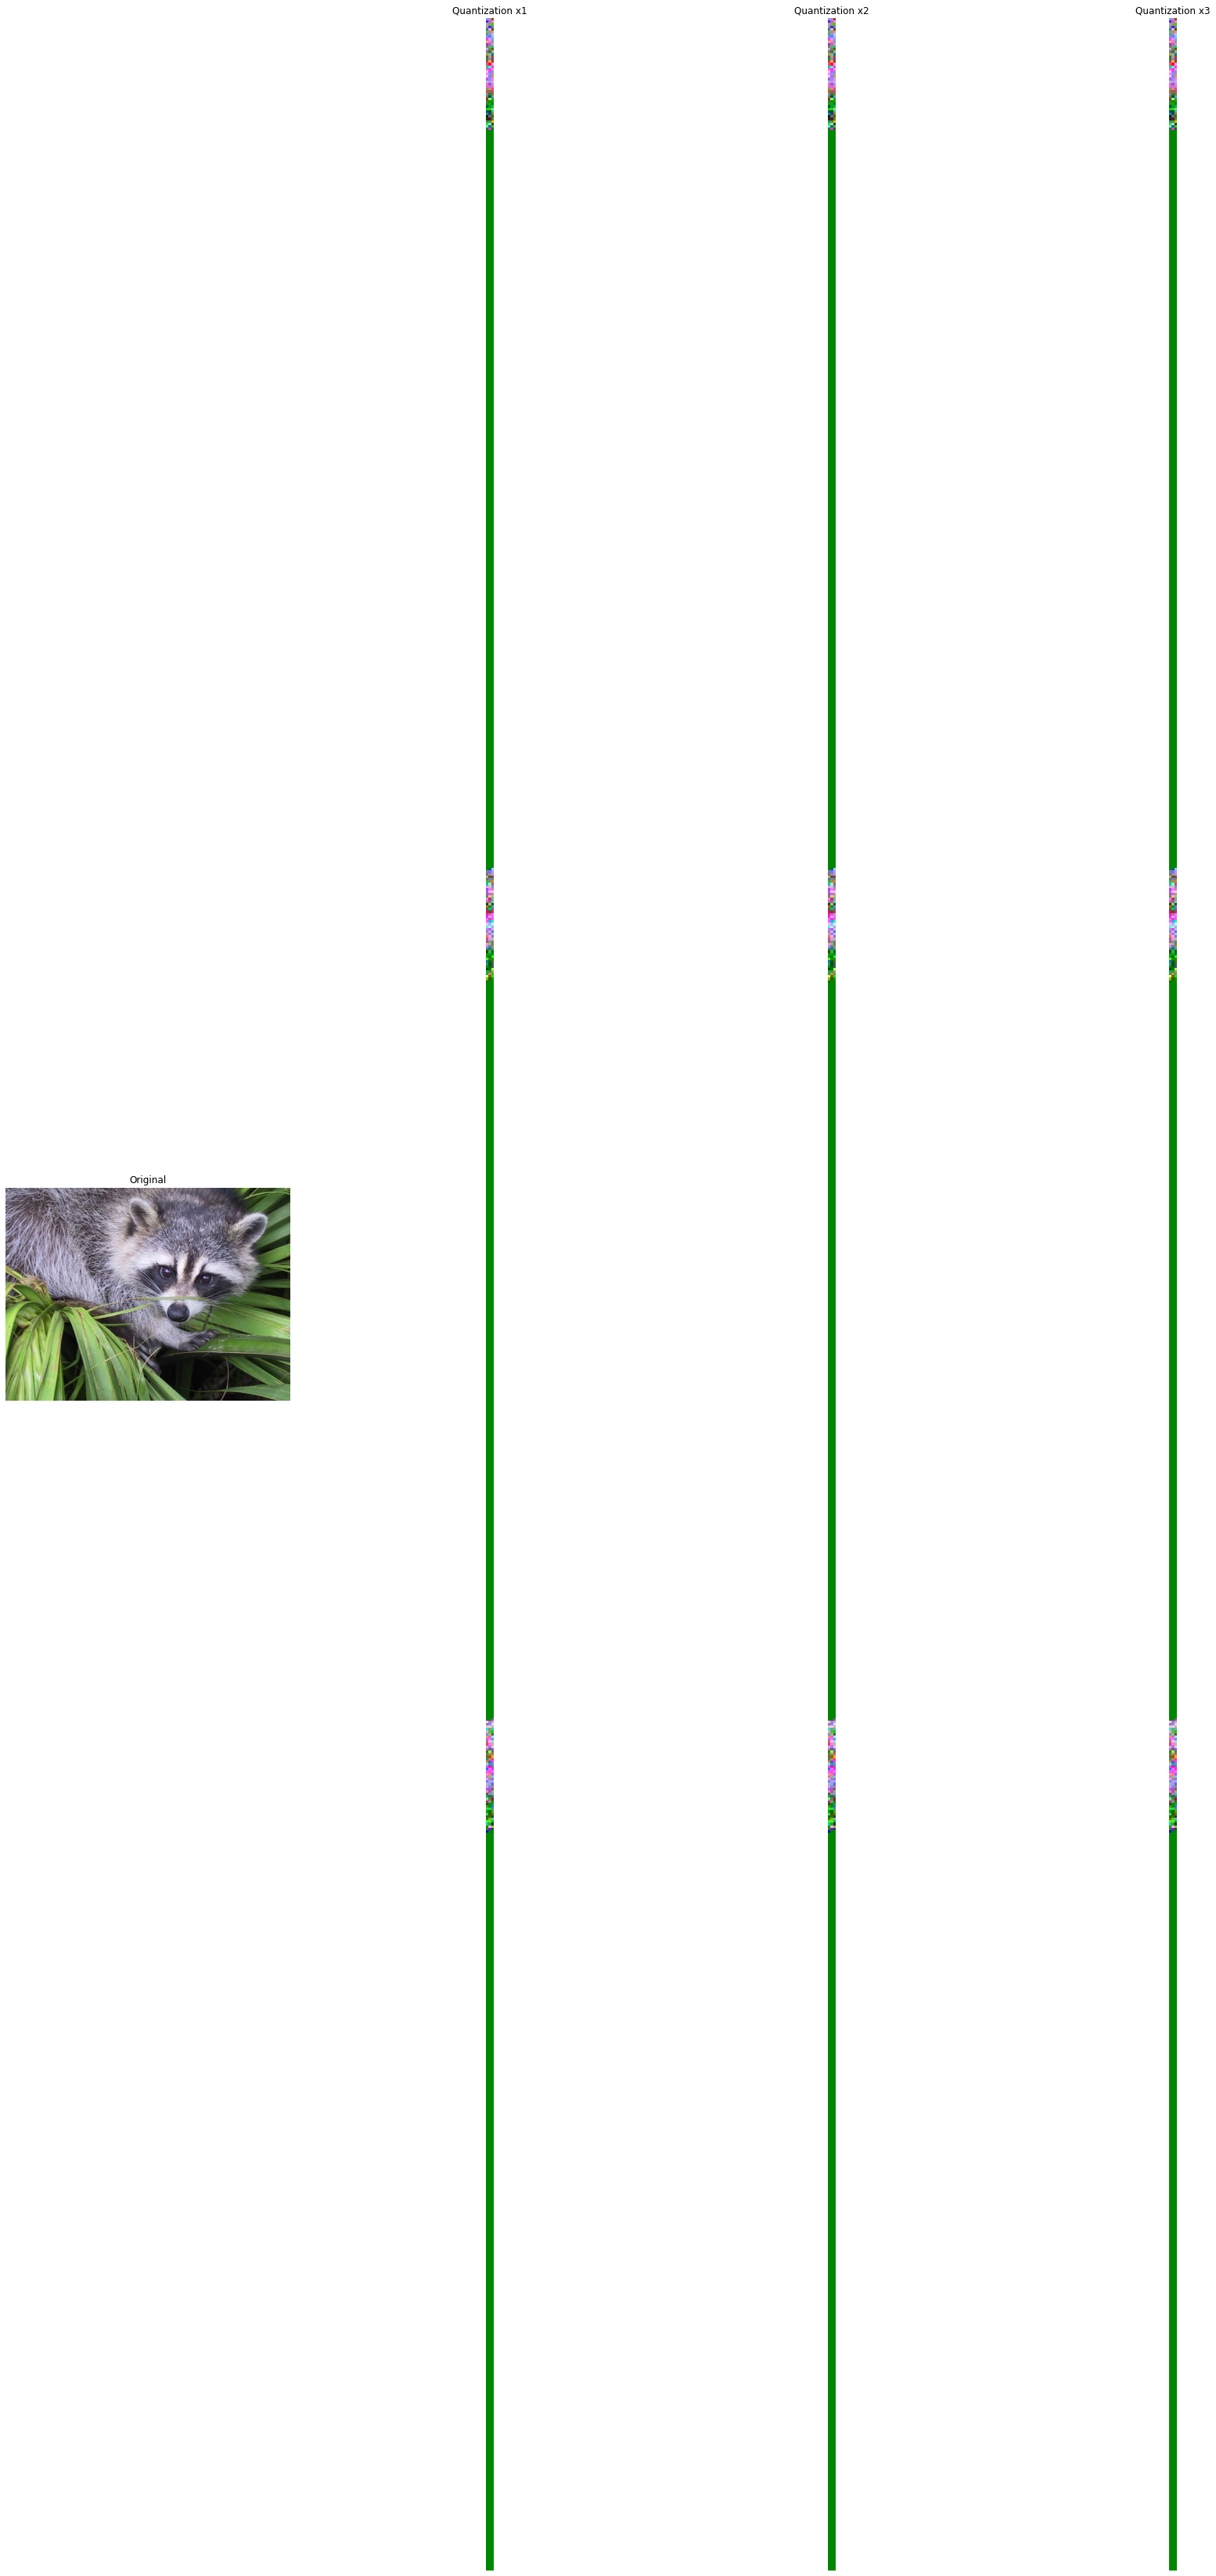

In [0]:
#@title Plotting

plt.figure(figsize=(30,60))
plt.subplot(141)
plt.imshow(raccoon_ycbcr)
plt.title("Original")
plt.axis('off')
plt.subplot(142)
plt.imshow(blocks_q1)
plt.title("Quantization x1")
plt.axis('off')
plt.subplot(143)
plt.imshow(blocks_q2)
plt.title("Quantization x2")
plt.axis('off')
plt.subplot(144)
plt.imshow(blocks_q3)
plt.title("Quantization x3")
plt.axis('off')
plt.show()

## 5. Histograms

Compute the histogram of an image and of its prediction error.

If the coordinates of the pixel being processed are $(m,n)$, consider:
1. predicting based on just the pixel at $(m-1, n)$,
1. predicting based on just the pixel at $(m, n+1)$,
1. predicting based on the average of the pixels at $(m-1, n)$, $(m-1, n+1)$ and $(m, n+1)$

## 6. Entropy

Compute the entropy for each one of the predictors in excercise 5.